,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Пропусков по столбцам:
 species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
Размер обучающей выборки: (249, 6)
Размер тестовой  выборки: (84, 6)

=== Accuracy ===
1.000

=== Подробный отчёт (precision / recall / f1) ===
              precision    recall  f1-score   support

      Adelie      1.000     1.000     1.000        37
   Chinstrap      1.000     1.000     1.000        17
      Gentoo      1.000     1.000     1.000        30

    accuracy                          1.000        84
   macro avg      1.000     1.000     1.000        84
weighted avg      1.000     1.000     1.000        84



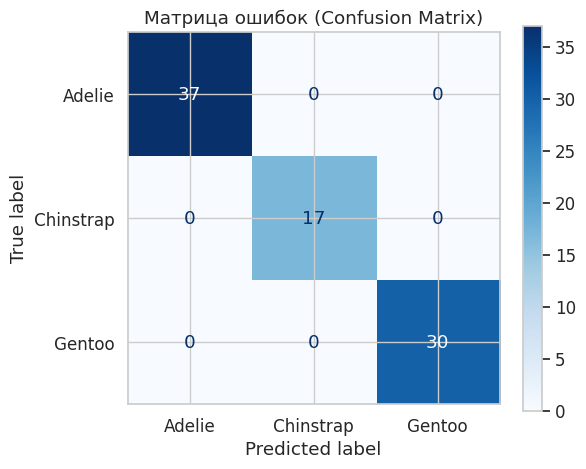

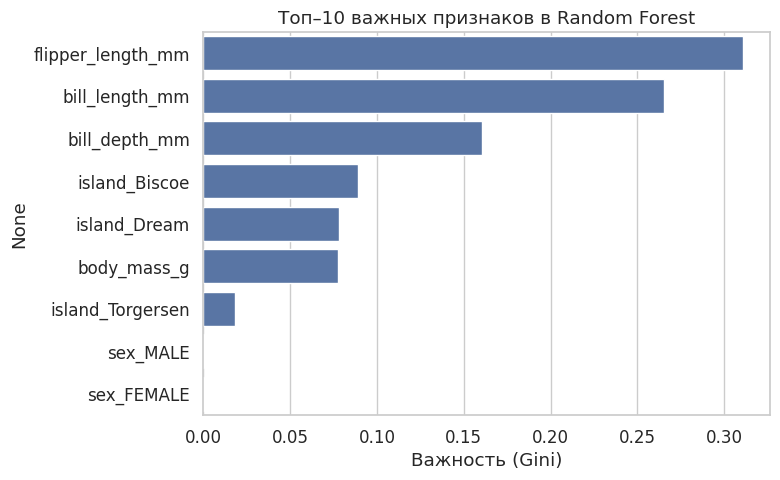

In [ ]:
# на всякий случай:
# !pip install scikit-learn seaborn matplotlib pandas --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier

# Визуализации будут аккуратнее
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
penguins = pd.read_csv(url)

# Быстрый взгляд
display(penguins.head())
print("Пропусков по столбцам:\n", penguins.isna().sum())


#  Предобработка
penguins = penguins.dropna()

# 2.2 — признаки и цель
X = penguins.drop(columns="species")
y = penguins["species"]

# 2.3 — какие колонки числовые / категориальные
num_cols  = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols  = X.select_dtypes(include=["object"]).columns


# 2.4 — пайплайн предобработки:
#       - числовые: стандартизация
#       - категориальные: One-Hot
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой  выборки:", X_test.shape)


#   Модель Random Forest=
rf_clf = RandomForestClassifier(
    n_estimators=200,       # 200 деревьев
    max_depth=2,        # без ограничения глубины
    random_state=42,
    n_jobs=-1              # использовать все ядра
)


model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf",   rf_clf)
])

# Обучаем
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\n=== Accuracy ===")
print(f"{accuracy_score(y_test, y_pred):.3f}")

print("\n=== Подробный отчёт (precision / recall / f1) ===")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", ax=ax,
    display_labels=model.classes_
)
ax.set_title("Матрица ошибок (Confusion Matrix)")
plt.show()

#  Важность признаков
rf = model.named_steps["rf"]
importances = rf.feature_importances_

# Однако после One-Hot список признаков разросся,
# поэтому возьмём имена из трансформера:
ohe_feature_names = model.named_steps["prep"]\
                         .named_transformers_["cat"]\
                         .get_feature_names_out(cat_cols)
all_feature_names = np.hstack([num_cols, ohe_feature_names])

# Сортируем по убыванию
feat_imp = (pd.Series(importances, index=all_feature_names)
              .sort_values(ascending=False))

# Топ-10 визуализируем
top_n = 10
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=feat_imp.head(top_n), y=feat_imp.head(top_n).index, ax=ax)
ax.set_title(f"Топ–{top_n} важных признаков в Random Forest")
ax.set_xlabel("Важность (Gini)")
plt.tight_layout()
plt.show()
